오토인코더 구현
  - latent variable에 어떤 정보가 있는지 시각화

In [1]:
# 필요한 라이브러리
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets 

In [3]:
# 출력한 이미지를 보기 위한 라이브러리
import matplotlib.pyplot as plt # 이미지 출력
from mpl_toolkits.mplot3d import Axes3D # matplotlib에서 3차원의 플롯을 그리기 위함
from matplotlib import cm # 데이터 포인트의 색상 입히기
import numpy as np 


In [4]:
# 하이퍼파라미터
EPOCH=10
BATCH_SIZE=64
USE_CUDA=torch.cuda.is_available()
DEVICE=torch.device('cuda' if USE_CUDA else 'cpu') # gpu 사용가능하면 gpu할당
print('Using Device',DEVICE)

Using Device cuda


In [5]:
# 학습 데이터셋
trainset=datasets.FashionMNIST(
    root='./.data/',
    train=True,
    download=True,
    transform=transforms.ToTensor() # 텐서로 변환 
)

train_loader=torch.utils.data.DataLoader( # 미니배치학습, 셔플,병렬처리를 위해서 dataloader 사용
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [6]:
#오토인코더 모듈 정의 (encoder와 decoder)
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder,self).__init__()
    self.encoder=nn.Sequential( #nn.Sequential : 여러 모듈을 하나로 묶는 역할 (계층-> 활성화함수)로 레이어를 나눠서 데이터를 순서대로 처리
        nn.Linear(28*28,128),# 784 차원에서 시작 
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,12),
        nn.ReLU(),
        nn.Linear(12,3),# latent variable: 3차원(특징 3개로 압축)
    )
    self.decoder=nn.Sequential( # 3차원의 latent variable를 784차원으로 복원
        nn.Linear(3,12),
        nn.ReLU(),
        nn.Linear(12,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Sigmoid(), # 출력값을 0과 1사이로 반환하도록
    )
  def forward(self,x):
    encoded=self.encoder(x) #잠재변수
    decoded=self.decoder(encoded) #복원이미지
    return encoded, decoded 

        

In [7]:
# 모델과 최적화함수,손실함수
autoencoder=Autoencoder().to(DEVICE) #모델 
optimizer=torch.optim.Adam(autoencoder.parameters(),lr=0.005) # 최적화함수 : 학습중인 기울기를 참고하여 학습속도를 자동으로 변화시킴 
#파이토치의 optim 모듈에는 SGD, RMSProp, Adam과 같은 최적화함수제공
# adam이랑 sgd에 관해서 더 공부 
criterion=nn.MSELoss() #평균제곱오차(mean squared loss) : 입력과 출력을 행렬로 받아서, 각 자리 값의 차이를 제곱하고 평균냄 

In [8]:
# 모델에 넣기 위한 이미지 전처리
view_data=trainset.data[:5].view(-1,28*28) # 데이터셋에 있는 5개의 이미지 전처리
view_data=view_data.type(torch.FloatTensor)/255 # 이미지 픽셀값은 0에서 255사이 값을 가짐, 모델이 인식하는 0~1사이 값으로 변환해주기 위함


In [13]:
# 학습하는 함수
def train(autoencoder,train_loader):
  autoencoder.train()
  for step, (x,label) in enumerate(train_loader):
    x=x.view(-1,28*28).to(DEVICE)
    y=x.view(-1,28*28).to(DEVICE) # 레이블 y= 원본이미지(x)
    label=label.to(DEVICE)

    encoded,decoded=autoencoder(x) # 모델 결과값

    loss=criterion(decoded,y) # 복원 이미지(decoded)와 원본이미지(y)의 평균제곱오차
    optimizer.zero_grad() # 기울기초기화
    loss.backward() # 기울기 구함
    optimizer.step() # 최적화 (파라미터값 갱신 )

[Epoch 1]


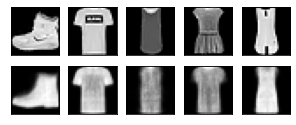

[Epoch 2]


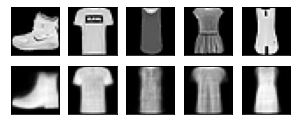

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbb89996160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbb89996160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[Epoch 3]


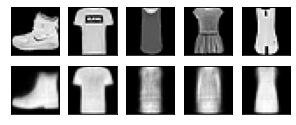

[Epoch 4]


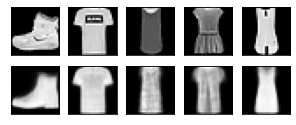

[Epoch 5]


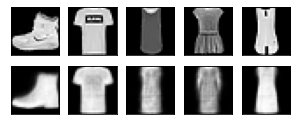

[Epoch 6]


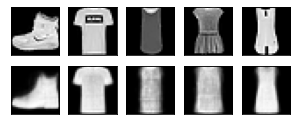

[Epoch 7]


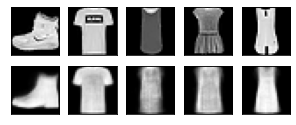

[Epoch 8]


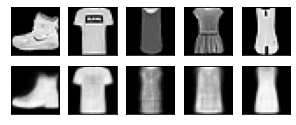

[Epoch 9]


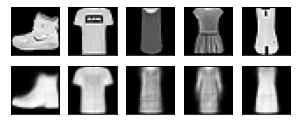

[Epoch 10]


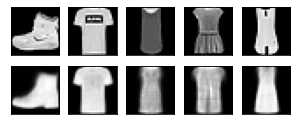

In [16]:
# 학습시킨 모델에 이미지 5개(test 셋)넣고 원본 vs 복원이미지 비교해보기
for epoch in range(1,EPOCH+1):
    train(autoencoder,train_loader) # 모델 학습

    test_x=view_data.to(DEVICE) 
    _,decoded_data=autoencoder(test_x)

    #원본과 디코딩 결과 비교
    f,a=plt.subplots(2,5,figsize=(5,2)) # 2줄 5칸으로 출력하도록
    print("[Epoch {}]".format(epoch))

    for i in range(5):
      img=np.reshape(view_data.data.numpy()[i],(28,28)) # matplotlib은 파이토치센서를 출력할 수없으므로 (28,28)의 넘파이행렬로 변환
      a[0][i].imshow(img,cmap='gray')
      a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
      img=np.reshape(decoded_data.to('cpu').data.numpy()[i],(28,28)) # 넘파이 행렬로 변환하기 전에 gpu에 있는 출력값을 일반메모리(cpu)로 가져옴
      a[1][i].imshow(img,cmap='gray')
      a[1][i].set_xticks(());a[1][i].set_yticks(())

    plt.show() 

- 잠재변수 시각화

In [29]:
# latent variable만 추출
view_data=trainset.data[:200].view(-1,28*28)
view_data=view_data.type(torch.FloatTensor)/255. # 모델의 입력에 넣게 0에서 1사이 값으로
test_x=view_data.to(DEVICE) # gpu로 모델 돌리기 위해서 데이터셋을 device로 보냄
encoded_data,_=autoencoder(test_x) 
encoded_data=encoded_data.to('cpu') # encoded 값을 다시 cpu로 가져옴(시각화해보기 위해)


In [30]:
# 잠재변수에 레이블 붙이기 위해 클래스 정의
CLASSES={
    0: 'T-shirt/top',
    1 : 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

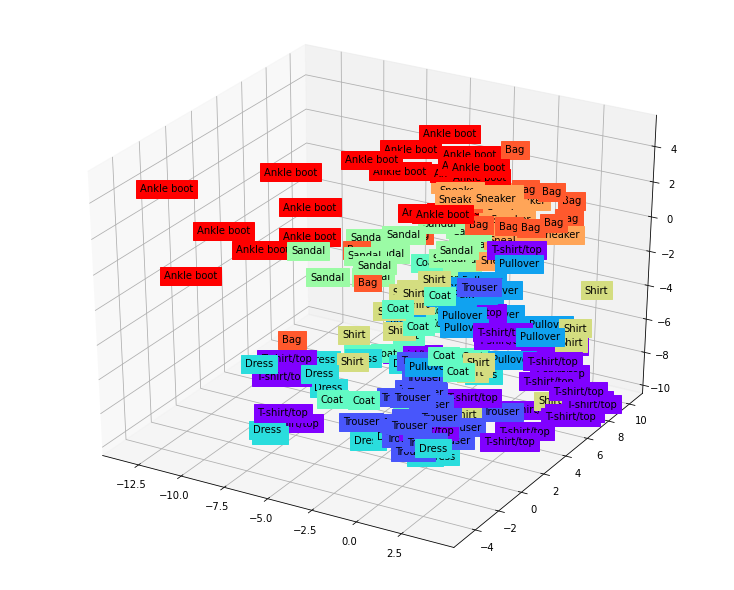

In [37]:
# 잠재변수 3차원(x,y,z값 따로 추출)
# labels : 200개 이미지가 각각 어느 클래스에 해당하는지 numpy 행렬로 변환

fig=plt.figure(figsize=(10,8))
ax=Axes3D(fig)

X=encoded_data.data[:, 0].numpy() # 200개의 latent 변수에서 x값들만 추출
Y=encoded_data.data[:, 1].numpy()
Z=encoded_data.data[:, 2].numpy()

labels=trainset.targets[:200].numpy() # 각 이미지마다 어느 클래스에 해당하는지 

for x,y,z,s in zip(X,Y,Z,labels):
    name=CLASSES[s] # 클래스
    color=cm.rainbow(int(255*s/9)) # 각 클래스마다 색깔다르게 입힘
    ax.text(x,y,z,name,backgroundcolor=color)

ax.set_xlim(X.min(),X.max())
ax.set_ylim(Y.min(),Y.max())
ax.set_zlim(Z.min(),Z.max())

plt.show()

- 결과 분석 : 
1) 같은 레이블을 가진 이미지의 잠재변수는 가까운곳에 위치
2) 윗옷(티셔츠,드레스,코트,셔츠)는 가깝거나 겹치고, 신발류들도 서로 가까이 자리함-> 비슷한 의미의 이미지라면 공간적으로 더 가깝다

6.3 오토인코더로 망가진 이미지 복원
- encoder : 데이터를 압축
  - 데이터를 압축 : 데이터의 특성에 우선순위를 매기고, 낮은 순위의 데이터는 버림
  - 잡음 = 낮은 순위의 데이터
- 잡음 제거 오토인코더 : 학습할 때 입력 + 잡음을 넣어서 잡음은 제거하도록 학습시킴


In [38]:
# 모델 입력 : 입력 + 잡음
def add_noise(img):
  noise=torch.randn(img.size())*0.2
  noisy_img=img+noise
  return noisy_img

In [39]:
from torch.optim.optimizer import Optimizer
def train(autoencoder,train_loader):
    autoencoder.train()
    avg_loss=0 
    for step, (x,label) in enumerate(train_loader):
        noisy_x=add_noise(x)
        noisy_x=noisy_x.view(-1,28*28).to(DEVICE)
        y=x.view(-1,28*28).to(DEVICE) # 원본이미지

        label=label.to(DEVICE)
        encoded,decoded=autoencoder(noisy_x) # latent variable, 복원 이미지

        loss=criterion(decoded,y) # 원본이미지와 복원이미지 평균제곱오차
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        avg_loss +=loss.item() # 배치마다 오차값을 더함 
    return avg_loss / len(train_loader) # 반복횟수만큼 나누어 평균을 구함(오차의 평균 )

In [40]:
for epoch in range(1,EPOCH+1):
    loss=train(autoencoder,train_loader)
    print("[Epoch {}] loss :{}".format(epoch,loss))

[Epoch 1] loss :0.022526529228398158
[Epoch 2] loss :0.022014429467096766
[Epoch 3] loss :0.021946397036123378
[Epoch 4] loss :0.021866163886241567
[Epoch 5] loss :0.021749701271496856
[Epoch 6] loss :0.021777912744009163
[Epoch 7] loss :0.021673176600448867
[Epoch 8] loss :0.021698557865073177
[Epoch 9] loss :0.0216992440472629
[Epoch 10] loss :0.021588050097084123


- 잡음 제거 시각화 

In [41]:
# 테스트셋으로 검증
testset=datasets.FashionMNIST(
    root='./.data/',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [42]:
# 이미지의 차원과 값의 범위 변환
sample_data=testset.data[0].view(-1,28*28) # 첫번째 데이터만 변환함(어차피 이미지 1개로 검증할거라..)
sample_data=sample_data.type(torch.FloatTensor)/255


In [43]:
original_x=sample_data[0] # 원본 이미지
noisy_x=add_noise(original_x).to(DEVICE) # 노이즈 섞인 이미지
_,recovered_x = autoencoder(noisy_x) # 복원이미지

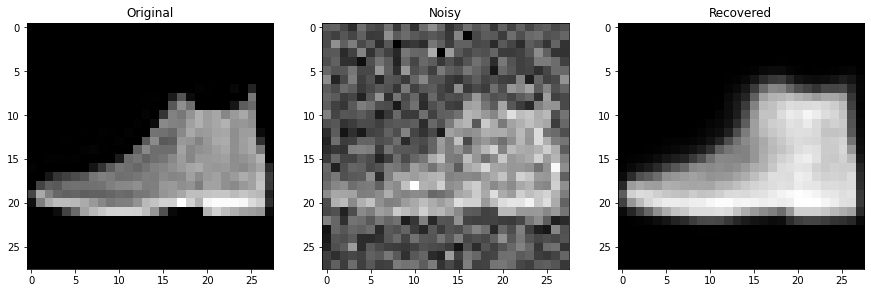

In [44]:
# 원본, 노이즈, 복원이미지 시각화 
f,a=plt.subplots(1,3,figsize=(15,15))

original_img=np.reshape(original_x.to('cpu').data.numpy(),(28,28))
noisy_img=np.reshape(noisy_x.to('cpu').data.numpy(),(28,28))
recovered_img=np.reshape(recovered_x.to('cpu').data.numpy(),(28,28))

a[0].set_title('Original')
a[0].imshow(original_img,cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img,cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img,cmap='gray')

plt.show()